# Gender By Names

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Exploratory Data Analysis 


In [6]:
df = pd.read_csv("/kaggle/input/gender-by-name/data.csv")

df['Name'] = df['Name'].str.lower().str.strip()

df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

df = df.drop_duplicates(subset=['Name'])

df = df.dropna(subset=['Name', 'Gender'])

print(df.shape)
print(df.head())
print(df['Gender'].value_counts())


(133910, 4)
      Name  Gender    Count  Probability
0    james       1  5304407     0.014517
1     john       1  5260831     0.014398
2   robert       1  4970386     0.013603
3  michael       1  4579950     0.012534
4  william       1  4226608     0.011567
Gender
0    83326
1    50584
Name: count, dtype: int64


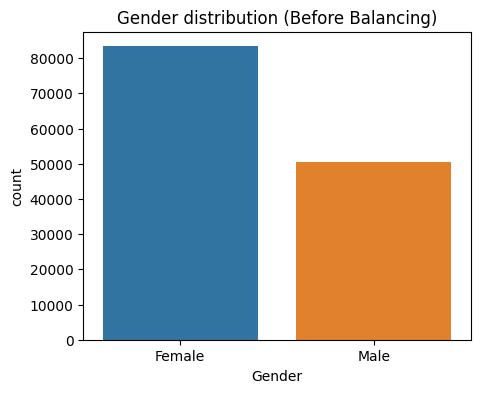

In [12]:
plt.figure(figsize=(5,4))
sns.countplot(x=df['Gender'])
plt.title("Gender distribution (Before Balancing)")
plt.xticks([0,1], ['Female','Male'])
plt.savefig("gender_distribution_before.png", dpi=300, bbox_inches='tight')
plt.show()

## Balancing the dataset

In [8]:
from sklearn.utils import resample

df_female = df[df['Gender'] == 0]
df_male   = df[df['Gender'] == 1]

df_female_down = resample(df_female,
                          replace=False,    
                          n_samples=len(df_male),
                          random_state=42)

df_balanced = pd.concat([df_female_down, df_male])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['Gender'].value_counts())

Gender
1    50584
0    50584
Name: count, dtype: int64


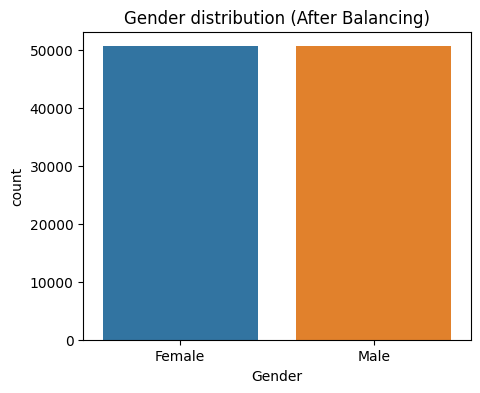

In [13]:
plt.figure(figsize=(5,4))
sns.countplot(x=df_balanced['Gender'])
plt.title("Gender distribution (After Balancing)")
plt.xticks([0,1], ['Female','Male'])
plt.savefig("gender_distribution_after.png", dpi=300, bbox_inches='tight')
plt.show()